Section 1: Bring in data and format properly

In [57]:
import zipfile
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

# Unzip Data
with zipfile.ZipFile("/content/boostbag.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Format Letter Dataset
with open("/content/letterCG.data") as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split()
      newLines.append( newLine )
letterData = np.array(newLines)
letterData = pd.DataFrame(data = letterData)
header = letterData.iloc[0]
letterData = letterData[1:]
letterData.columns = header
letterData = letterData.drop(letterData[(letterData.Class != 'C') & (letterData.Class != 'G')].index)
letterY = letterData.Class
letterX = letterData.drop(['Class'], axis=1)
letterY = letterY.replace('G', -1)
letterY = letterY.replace('C', 1)
print(letterX.shape)


# Format Credit Dataset
with open("/content/credit.data") as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split()
      newLines.append( newLine )
creditData = np.array(newLines)
creditData = pd.DataFrame(data = creditData)
header = creditData.iloc[0]
creditData = creditData[1:]
creditData.columns = header
creditY = creditData.Class
creditX = creditData.drop(['Class'], axis=1)
creditY = creditY.replace("bad", -1)
creditY = creditY.replace("good", 1)
print(creditX.shape)

# Format Spam Dataset
with open("/content/spam.data") as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split()
      newLines.append( newLine )
spamData = np.array(newLines)
spamData = pd.DataFrame(data = spamData)
header = spamData.iloc[0]
spamData = spamData[1:]
spamData.columns = header
spamY = spamData.Class
spamX = spamData.drop(['Class'], axis=1)
spamY = spamY.replace("ham", -1)
spamY = spamY.replace("spam", 1)
print(spamX.shape)

(1509, 16)
Index(['Class', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar',
       'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege',
       'yegvx'],
      dtype='object', name=0)
(1000, 20)
(4601, 57)


Section 2: Write a function Boost.ipynb


In [78]:
from sklearn.tree import DecisionTreeClassifier
from math import log
from math import exp

def Boost(trainX, testX, trainY, testY, T, clf):
  # size of training data
  n = len(trainX)
  nY = len(testX)

  # create unweighted data
  weights = np.ones(n) / n

  #predictions for training/testing
  trainPredictions = np.zeros(n)
  testPredictions = np.zeros(nY)



  for t in range(T):
    clf.fit(trainX, trainY, sample_weight = weights)
    ptrain = clf.predict(trainX)
    ptest = clf.predict(testX)
    #indication
    ind = [int(x) for x in (ptrain != trainY)]
    ind2 = [x if x==1 else -1 for x in ind]
    #Error
    er = np.dot(weights, ind) / sum(weights)
    #Alpha
    a = 0.5 * np.log( (1 - er) / float(er))
    #Update weights
    weights = np.multiply(weights, np.exp([float(x) * a for x in ind2]))
    #add predictions
    trainPredictions = [sum(x) for x in zip(trainPredictions, [x * a for x in ptrain])]
    testPredictions = [sum(x) for x in zip(testPredictions, [x * a for x in ptest])]

  trainPredictions = np.sign(trainPredictions)
  testPredictions = np.sign(testPredictions)
  trainE = sum(trainPredictions != trainY) / float(len(trainY))
  testE = sum(testPredictions != testY) / float(len(testY))
  return trainPredictions, testPredictions, trainE, testE

def runBoost(trainX, testX, trainY, testY, depth):
  trainError = []
  testError = []
  
  #base learner
  clf = DecisionTreeClassifier(max_depth = depth)
  clf.fit(trainX, trainY)
  ptrain = clf.predict(trainX)
  ptest = clf.predict(testX)
  #base learner error
  print("Base learner training error")
  trainErrorBase = sum(ptrain != trainY) / float(len(trainY))
  print(sum(ptrain != trainY) / float(len(trainY)))
  print("Base learner testing error")
  testErrorBase = sum(ptest != testY) / float(len(testY))
  print(sum(ptest != testY) / float(len(testY)))
  #add base errors to error
  trainError.append(trainErrorBase)
  testError.append(testErrorBase)
  rangeT = range(10, 410, 10)
  for T in rangeT:
    #run boost and update train/test errors and return final classifier
    trainP, testP, trainE, testE = Boost(trainX, testX, trainY, testY, T, clf)
    trainError.append(trainE)
    testError.append(testE)
  return trainP, testP, trainError, testError

Section 3: Write a function Bagging.ipynb

In [77]:
def bagging(trainX, testX, trainY, testY, T, clf):
  #Add data together so it stays intact when sampleing
  train = pd.concat([trainX, trainY], axis=1, sort=False)
  # size of training data
  n = len(trainX)
  nY = len(testX)

  #predictions for training/testing
  trainPredictions = np.zeros(n)
  testPredictions = np.zeros(nY)
  trees = list()
  for t in range(T):
    sample = train.sample(n=n, replace=True)
    #seperate sample into X / Y
    sampleY = sample.Class
    sampleX = sample.drop(['Class'], axis=1)
    clf.fit(sampleX, sampleY)
    # trainP = clf.predict(trainX)
    #add to training predictions
    trees.append(clf)
  trainPredictions = predict(trees, trainX)
  testPredictions = predict(trees, testX)
  testPredictions = np.sign(testPredictions)
  trainPredictions = np.sign(trainPredictions)
  trainE = sum(trainPredictions != trainY) / float(len(trainY))
  testE = sum(testPredictions != testY) / float(len(testY))

  return trainPredictions, testPredictions, trainE, testE
  
# voting for most common tree  
def predict(trees, data):
  numTrees = len(trees)
  samples = len(data)
  predictions = np.zeros((samples, numTrees))
  for i in range(numTrees):
    predictions[:,i] = trees[i].predict(data)
  # list of modes for each sample
  modes = []
  for i in range(samples):
    samplePred = predictions[i,:].tolist()
    # print("trees predict row " + i + " is " + samplePred)
    modes.append(int(max(set(samplePred), key = samplePred.count)))
    # print("Most common is " + modes)
  return modes

def runBagging(trainX, testX, trainY, testY, depth):
  trainError = []
  testError = []

  #base learner
  clf = DecisionTreeClassifier(max_depth = depth, random_state = 1)
  clf.fit(trainX, trainY)
  ptrain = clf.predict(trainX)
  ptest = clf.predict(testX)
  #base learner error
  print("Base learner training error")
  trainErrorBase = sum(ptrain != trainY) / float(len(trainY))
  print(sum(ptrain != trainY) / float(len(trainY)))
  print("Base learner testing error")
  testErrorBase = sum(ptest != testY) / float(len(testY))
  print(sum(ptest != testY) / float(len(testY)))
  #add base errors to error
  trainError.append(trainErrorBase)
  testError.append(testErrorBase)
  rangeT = range(10, 410, 10)
  for T in rangeT:
    #run boost and update train/test errors and return final classifier
    trainP, testP, trainE, testE = bagging(trainX, testX, trainY, testY, T, clf)
    trainError.append(trainE)
    testError.append(testE)
  return trainP, testP, trainError, testError

Section 4: Graphing Function

In [79]:
import matplotlib.pyplot as plt
#function to plot error rates
def trainVsTestError(trainE, testE, boostBag):
  error = pd.DataFrame([trainE, testE]).T
  error.columns = ['Training Error', 'Testing Error']
  plot = error.plot(figsize = (10,8), color = ['red', 'blue'], grid = True)
  plot.set_ylabel("Error Rate")
  plot.set_xticklabels(range(0,450,50))
  if(boostBag == 1):
    plot.set_xlabel("Rounds of Boosting T")
    plot.set_title("Error rate vs. Rounds of Boosting using AdaBoost Algorithm")
  else:
    plot.set_xlabel("Rounds of Bagging T")
    plot.set_title("Error rate vs. Rounds of Bagging")

*Analysis*:


Section 5: Boosting on Stumps (depth = 1)

Base learner training error
0.228
Base learner testing error
0.2130822596630327
#########################################################################
Base learner training error
0.22553897180762852
Base learner testing error
0.2240618101545254
Base learner training error
0.21100917431192662
Base learner testing error
0.22842639593908629


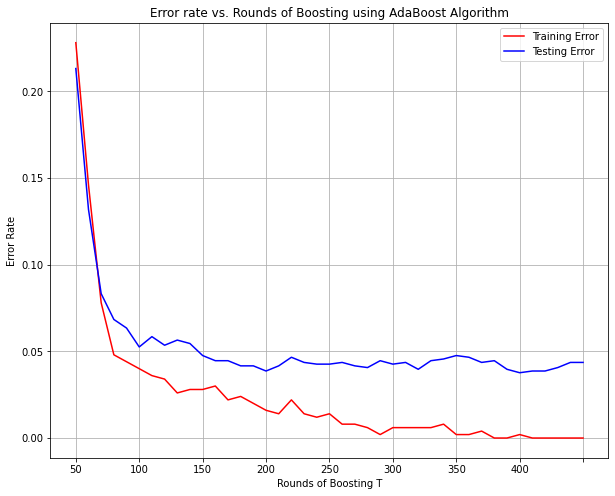

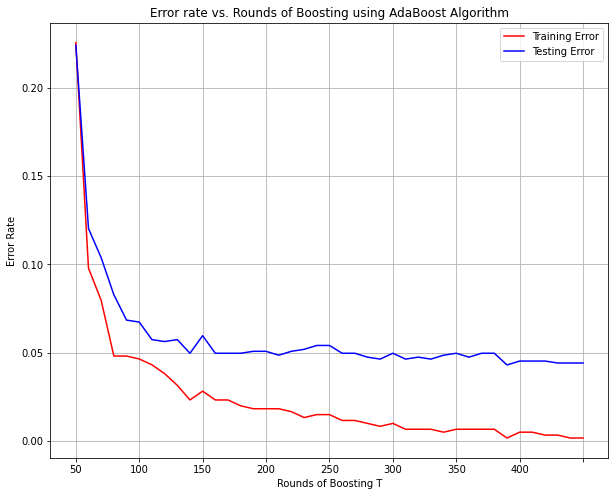

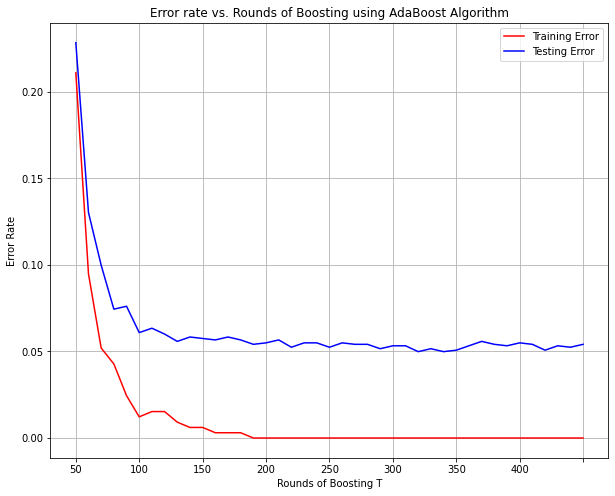

In [80]:
from sklearn.model_selection import train_test_split
depth = 1

# run on letter dataset (500 training and 1009 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6686547382)
trainingPredictionsL, testingPredictionsL, trainingErrorL, testingErrorL = runBoost(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorL, testingErrorL,1)
print('#########################################################################')
# # run on credit dataset (400 training and 600 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6)
trainingPredictionsC, testingPredictionsC, trainingErrorC, testingErrorC = runBoost(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorC, testingErrorC,1)
# print('#########################################################################')
# # run on spam dataset (1000 training and 3601 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.7826559444)
trainingPredictionsS, testingPredictionsS, trainingErrorS, testingErrorS = runBoost(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorS, testingErrorS,1)

Section 6: Boosting on Large Trees (max_depth = 5)

Base learner training error
0.028
Base learner testing error
0.061446977205153616
#########################################################################
Base learner training error
0.03316749585406302
Base learner testing error
0.06070640176600441
Base learner training error
0.04281345565749235
Base learner testing error
0.11928934010152284


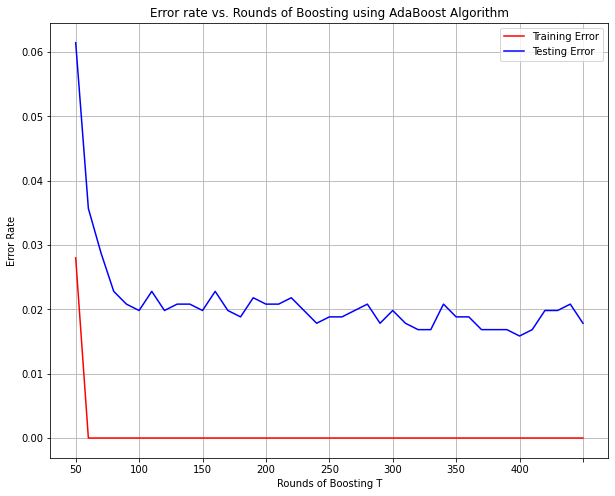

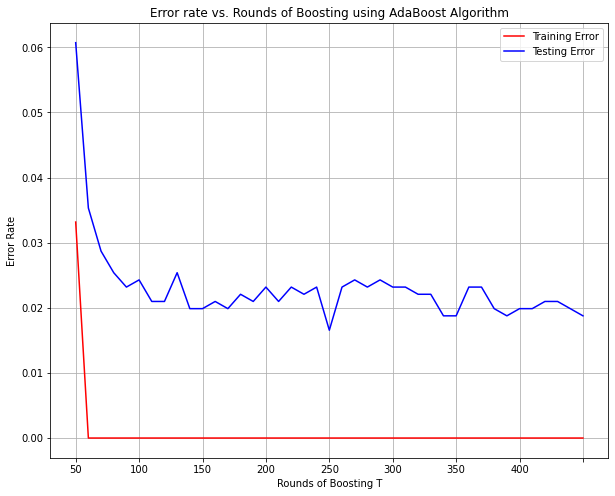

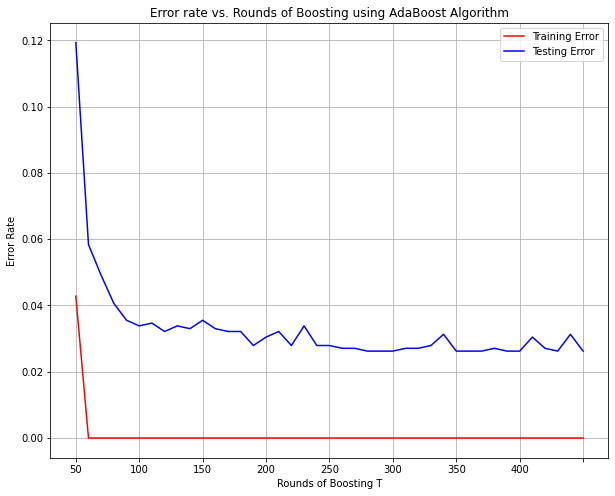

In [81]:
depth = 5

# run on letter dataset (500 training and 1009 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6686547382)
trainingPredictionsL, testingPredictionsL, trainingErrorL, testingErrorL = runBoost(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorL, testingErrorL,1)
print('#########################################################################')
# # run on credit dataset (400 training and 600 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6)
trainingPredictionsC, testingPredictionsC, trainingErrorC, testingErrorC = runBoost(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorC, testingErrorC,1)
# print('#########################################################################')
# # run on spam dataset (1000 training and 3601 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.7826559444)
trainingPredictionsS, testingPredictionsS, trainingErrorS, testingErrorS = runBoost(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorS, testingErrorS,1)

Section 7: Bagging on Stumps (max_depth = 1)


Base learner training error
0.206
Base learner testing error
0.22398414271555997
#########################################################################
Base learner training error
0.22388059701492538
Base learner testing error
0.2141280353200883
Base learner training error
0.19877675840978593
Base learner testing error
0.2233502538071066


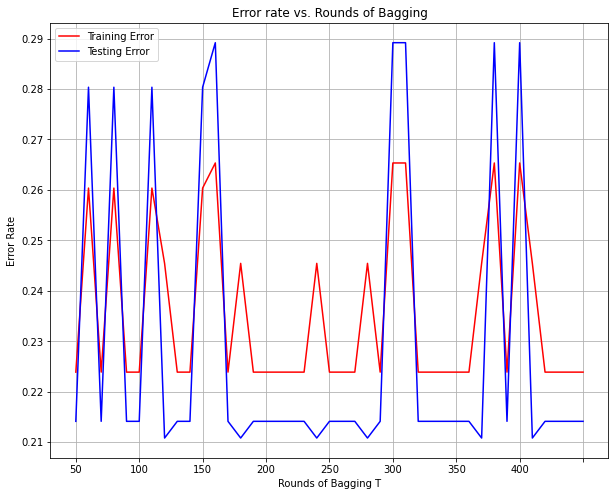

In [84]:
depth = 1

# run on letter dataset (500 training and 1009 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6686547382)
trainingPredictionsL, testingPredictionsL, trainingErrorL, testingErrorL = runBagging(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorL, testingErrorL,9)
print('#########################################################################')
# # run on credit dataset (400 training and 600 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6)
trainingPredictionsC, testingPredictionsC, trainingErrorC, testingErrorC = runBagging(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorC, testingErrorC,9)
# print('#########################################################################')
# # run on spam dataset (1000 training and 3601 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.7826559444)
trainingPredictionsS, testingPredictionsS, trainingErrorS, testingErrorS = runBagging(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorS, testingErrorS,9)

Section 8: Bagging on Large Trees (max_depth = 10)

Base learner training error
0.034
Base learner testing error
0.09712586719524281
#########################################################################
Base learner training error
0.04145936981757877
Base learner testing error
0.0717439293598234
Base learner training error
0.0672782874617737
Base learner testing error
0.07698815566835872


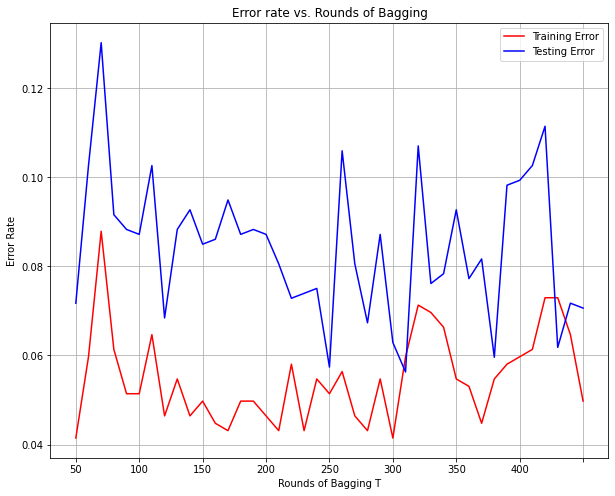

In [85]:
depth = 5

# run on letter dataset (500 training and 1009 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6686547382)
trainingPredictionsL, testingPredictionsL, trainingErrorL, testingErrorL = runBagging(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorL, testingErrorL,9)
print('#########################################################################')
# # run on credit dataset (400 training and 600 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6)
trainingPredictionsC, testingPredictionsC, trainingErrorC, testingErrorC = runBagging(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorC, testingErrorC,9)
# print('#########################################################################')
# # run on spam dataset (1000 training and 3601 testing)
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.7826559444)
trainingPredictionsS, testingPredictionsS, trainingErrorS, testingErrorS = runBagging(trainX, testX, trainY, testY, depth)
trainVsTestError(trainingErrorS, testingErrorS,9)

Section 9: Performance

For the initial testing of my Bootstrap algorithm, based on adaboost algorithm, and my Bagging algorithm, based on random forest model, I chose to run them on small decision tree classifiers. These classifiers had a depth of 1 and are usually reffered to as stumps. I began by creating a Decision Tree Classifier using Sklearn's built in decision tree classifier function. With a tree depth of 1 the baseline training and test error was roughly the same at 20% - 22%. This is a relatively poor classifier which provided a great deal of room for improvement. As shown by the "error vs boost rounds" graphs in section 5, all three datasets were able to be classified relatively well using a simple stump classifier in combination with the adaboost algorithm. Each data set, with the stump classifier, saw a steep reduction in error within the first 100 rounds of boosting. After 100 rounds, the algorithm didn't improve very much. Both the credit and spam datasets were able to be classified with a testing error just below 5% while the letter dataset was classified with a testing error just over 5% using the stump classifier with adaboost. Looking at how the the adaboost algorithm performs with deeper trees, max_depth=5, we see the initial baseline classifier is already much improved with a baseline training error and testing error between 0 and 10% depending on the dataset being fit. Similar to the stump classifier with adaboost, the deeper trees saw a steep reduction in error within the first blank boosting rounds. After that the letter, credit, and spam datasets were able to be classified with approximately 2%, 1%, and 1.5% error respectively. The one caveat with the larger trees is that they all produce a training error of 0 using the adaboost algorithm. This means there is for sure some overfitting occuring. 

Moving to the bagginng algorithm, we first use the algorithm in conjunction with a stump classifier for the supplied datasets. The baseline classifier is the same as the adaboost algorithm hovering around 20% - 22% error for both the training and testing error. I was fairly confused with this algorithm after running the it with stumps. I spent hours combing through my code, implementing new versions, with no improvement. My confusion stemmed from the fact that I was not seeing any improvement in classification. Whether it was the majority classification of 10 trees fitted on randomly sampled data or 400 trees, the classifiers' errors remained at the baseline. After discussing with Anuj Godase, I was able to understand why the bagging algorithm was not able to show improvement, but more on that later. Next, I classified the datasets using the deeper trees, max_depth=5. Similar to the stumps, the bagging algorithm wasn't able to improve the overall classification from the baseline of 0-10%. 

Section 10: Comparison

The algorithms have a large gap in their performance seeing as how the boosting algorithm improved drastically while the bagging algorithm didn't improve at all. This can be attributed to the underlying behavior of the algorithms. Boosting works by running a classifier on a dataset for T rounds. Each round the classifier will look at which features were responsible for incorrectly classifying a data point. The algorithm will then emphasize these features in subsequent boosting rounds by weighting these features. The more boosting round, up until around 100, the adaboost algorithm will become more and more accurate. This differs from the bagging algorithm which doesn't show any improvement the greater the number of bagging rounds. As Anuj explained to me there is no gaurentee that bagging will improve a classification. Bagging works by fitting a baseline classifier with randomly sampled data with replacement from the original dataset. If the bagging algorithm is set for T bagging rounds, then there will be T classifiers which will be fit on different samples of the data. The algorithm then uses all T classifiers to predict what the classification will be. Taking the majority vote off all these classifiers will produce the end classification. Because the data is the sampled from the same source, there is no improvement in each individual classifier, which leads each classifier to classify datapoint similarly. Overall, the adaboost algorithm is much more effective in reducing error, and in return classification.  

Section 11: Bagging's underlying assumptions

If the model has very poor performance, baggin will rarely get a better bias. However, if the model is overfitting, then Bagging might be of use. Bagging can be an effective approach to reduce the variance of a model, to prevent over fitting, and increase the accuracy of such an unstable model. 


Section 12: Other Observations

Below you will see a couple more experiments I ran on my boosting and bagging algorithms. I wanted to see how my boosting algorithm compared to the adaboost algorithm of sklearn. I also looked at how the bagging algorithm worked on randomly sampled data with a size less then the original dataset. I also compared my bagging algorithm with the random forest classifier of sklearn. 


To my surprise my boosting algorithm was able to outperform the adaboost algorithm from sklearn by almost 100% (sklearn testing error: 4%, my adaboost testing error: 2%). Unsurprisingly, taking a smaller sample of the total dataset for fitting the trees in the bagging model did not improve classification. This makes sense because of the underlying behavior of the algorithm. Taking different samples from the same dataset does not change the classification as the model is still being fit on essentially the same data. Finally, I decided to compare my bagging algorithm with the random forest algorithm of sklearn, which is essentially a bagging algorithm. Similar to my algorithm, there was no improvement from the baseline classifier, providing further evidence that bagging does not improve classification on the provided datasets. 

Base learner training error
0.2
Base learner testing error
0.22695738354806738


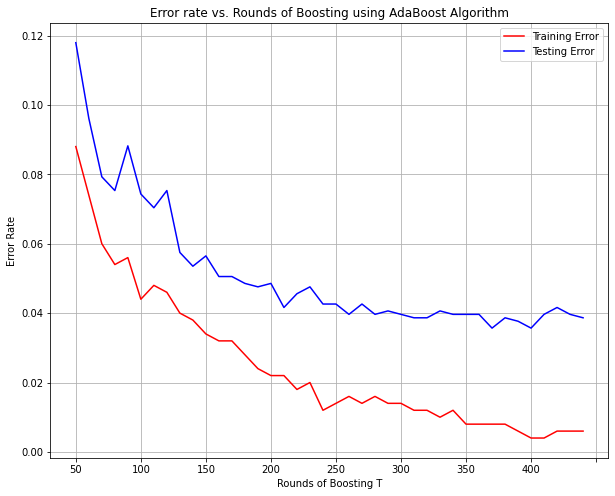

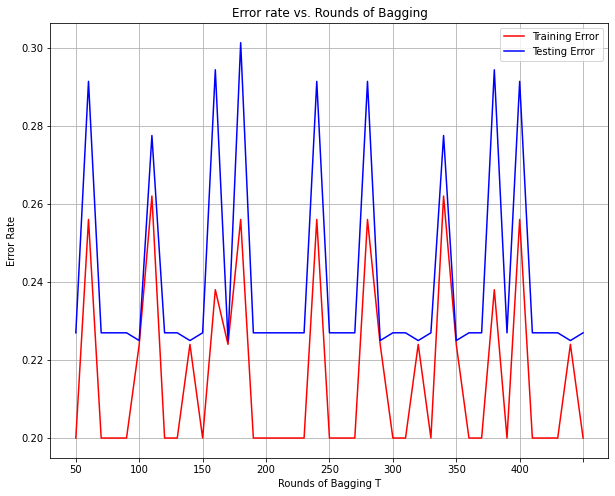

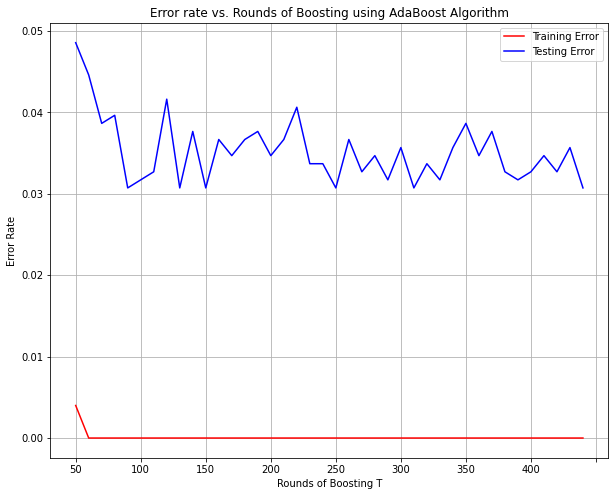

In [90]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
trainX, testX, trainY, testY = train_test_split(letterX, letterY, test_size = 0.6686547382)
# only running on letter dataset for comparison
trainError = []
testError = []
rangeT = range(10, 410, 10)
for t in rangeT:
  adaboost = AdaBoostClassifier(n_estimators = t, learning_rate=1, algorithm='SAMME')
  adaboost.fit(trainX, trainY)
  #train error
  trainE = adaboost.score(trainX, trainY)
  #test error
  testE = adaboost.score(testX, testY)
  trainError.append(1 - trainE)
  testError.append(1 - testE)
trainVsTestError(trainError, testError,1)

###################################################################################
############################# Bagging on < n samples ##############################
def bagging(trainX, testX, trainY, testY, T, clf):
  #Add data together so it stays intact when sampleing
  train = pd.concat([trainX, trainY], axis=1, sort=False)
  # size of training data
  n = len(trainX)
  nY = len(testX)

  #predictions for training/testing
  trainPredictions = np.zeros(n)
  testPredictions = np.zeros(nY)
  trees = list()
  for t in range(T):
    ################################################################################
    ####################### this is what I am changing #############################
    ############################## n = 300 #########################################
    sample = train.sample(n=300, replace=True)
    #seperate sample into X / Y
    sampleY = sample.Class
    sampleX = sample.drop(['Class'], axis=1)
    clf.fit(sampleX, sampleY)
    # trainP = clf.predict(trainX)
    #add to training predictions
    trees.append(clf)
  trainPredictions = predict(trees, trainX)
  testPredictions = predict(trees, testX)
  testPredictions = np.sign(testPredictions)
  trainPredictions = np.sign(trainPredictions)
  trainE = sum(trainPredictions != trainY) / float(len(trainY))
  testE = sum(testPredictions != testY) / float(len(testY))

  return trainPredictions, testPredictions, trainE, testE
  
# voting for most common tree  
def predict(trees, data):
  numTrees = len(trees)
  samples = len(data)
  predictions = np.zeros((samples, numTrees))
  for i in range(numTrees):
    predictions[:,i] = trees[i].predict(data)
  # list of modes for each sample
  modes = []
  for i in range(samples):
    samplePred = predictions[i,:].tolist()
    # print("trees predict row " + i + " is " + samplePred)
    modes.append(int(max(set(samplePred), key = samplePred.count)))
    # print("Most common is " + modes)
  return modes

def runBagging(trainX, testX, trainY, testY, depth):
  trainError = []
  testError = []

  #base learner
  clf = DecisionTreeClassifier(max_depth = depth, random_state = 1)
  clf.fit(trainX, trainY)
  ptrain = clf.predict(trainX)
  ptest = clf.predict(testX)
  #base learner error
  print("Base learner training error")
  trainErrorBase = sum(ptrain != trainY) / float(len(trainY))
  print(sum(ptrain != trainY) / float(len(trainY)))
  print("Base learner testing error")
  testErrorBase = sum(ptest != testY) / float(len(testY))
  print(sum(ptest != testY) / float(len(testY)))
  #add base errors to error
  trainError.append(trainErrorBase)
  testError.append(testErrorBase)
  rangeT = range(10, 410, 10)
  for T in rangeT:
    #run boost and update train/test errors and return final classifier
    trainP, testP, trainE, testE = bagging(trainX, testX, trainY, testY, T, clf)
    trainError.append(trainE)
    testError.append(testE)
  return trainP, testP, trainError, testError

############################### run alg ######################################
trainingPredictionsL, testingPredictionsL, trainingErrorL, testingErrorL = runBagging(trainX, testX, trainY, testY, 1)
trainVsTestError(trainingErrorL, testingErrorL,9)

######################### compare to random forrest classifier ##################
trainError = []
testError = []
rangeT = range(10, 410, 10)
for t in rangeT:
  bag = RandomForestClassifier(n_estimators=t,criterion="entropy")
  bag.fit(trainX, trainY)
  #train error
  trainE = bag.score(trainX, trainY)
  #test error
  testE = bag.score(testX, testY)
  trainError.append(1 - trainE)
  testError.append(1 - testE)
trainVsTestError(trainError, testError,1)